## 1. Import Libraries

In [1]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime

from tensorflow.keras.callbacks import EarlyStopping

## 2. Neural Newtork Architecture


In [2]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(
    filters=64, 
    kernel_size=(3, 3), 
    strides=1, 
    activation="relu", 
    padding="same", 
    input_shape=(32,32,3)))
model.add(ks.layers.Conv2D(
    filters=64, 
    kernel_size=(3, 3), 
    strides=1, 
    activation="relu", 
    padding="same", 
    input_shape=(32,32,3)))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Conv2D(
    filters=64, 
    kernel_size=(3, 3), 
    strides=1, 
    activation="relu", 
    padding="same", 
    input_shape=(32,32,3)))
model.add(ks.layers.Conv2D(
    filters=128, 
    kernel_size=(3, 3), 
    strides=1, 
    activation="relu", 
    padding="same", 
    input_shape=(32,32,3)))
model.add(ks.layers.Conv2D(
    filters=128, 
    kernel_size=(3, 3), 
    strides=1, 
    activation="relu", 
    padding="same", 
    input_shape=(32,32,3)))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Conv2D(
    filters=256, 
    kernel_size=(3, 3), 
    strides=1, 
    activation="relu", 
    padding="same", 
    input_shape=(32,32,3)))
model.add(ks.layers.Conv2D(
    filters=256, 
    kernel_size=(3, 3), 
    strides=1, 
    activation="relu", 
    padding="same", 
    input_shape=(32,32,3)))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(512, activation="relu"))
model.add(ks.layers.Dense(512, activation="relu"))
model.add(ks.layers.Dense(512, activation="relu"))
model.add(ks.layers.Dense(10, activation="softmax"))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0

## 3. Cost function


In [4]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 4. Data Preparation

We load the CIFAR10 dataset directly from Keras. Those are already split in train and test.


**Important:** 
> The neural network requires for the inputs to be real numbers. We can simply achieve this by divinding the values inside the matrices by 255.0.

In [5]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

In [6]:
y_train_label = y_train

#y_test = ks.utils.to_categorical(y_test)
#y_train = ks.utils.to_categorical(y_train)

y_test
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [7]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


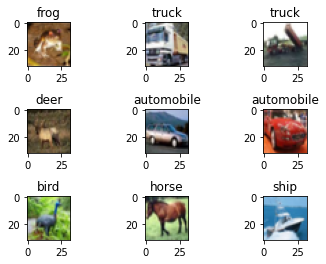

In [8]:
# Let's plot a sample of the images

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train_label[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

In [9]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]


When we add convolutions, we need to preprocess the data, because **convolution is for an array of 4 fields** (more like "images"), not an array of 3 dimensions as the datasets for train, test and validation. So we need to **.reshape()**.

That's why, when you exit the convolution, you have to flatten the matrices, because the FullDense layers expect arrays, not matrices!


In [10]:
# Let's validate the results
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
Validation: X=(10000, 32, 32, 3), y=(10000, 1)


# 4. Early Stopping

In [11]:
callback_loss = EarlyStopping(monitor="val_loss", patience=15)
callback_accuracy = EarlyStopping(monitor="val_accuracy", patience=10)

## 5. Training

Note that we have to train against the data converted to the format expected by the Convolution.

We will start with 30 epochs, that is to say, 30 complete passes of the dataset (which in turn will be with mini-batches internally, setting the batches to 64 elements.

The .fit() method allows us to define if we have several CPUs, GPUs, and if we want to validate data at each end of epoch.

In [12]:
t = time.perf_counter()

In [13]:
history = model.fit(x_train, y_train, 
                    epochs=128, 
                    use_multiprocessing=False, 
                    batch_size= 512, 
                    callbacks=[callback_accuracy, callback_loss],
                    validation_data=(x_val, y_val))

Epoch 1/128
79/79 [==============================] - 16s 124ms/step - loss: 2.2377 - accuracy: 0.1450 - val_loss: 2.0245 - val_accuracy: 0.2611
Epoch 2/128
79/79 [==============================] - 8s 99ms/step - loss: 1.7622 - accuracy: 0.3395 - val_loss: 1.5044 - val_accuracy: 0.4547
Epoch 3/128
79/79 [==============================] - 8s 100ms/step - loss: 1.4385 - accuracy: 0.4698 - val_loss: 1.3708 - val_accuracy: 0.4963
Epoch 4/128
79/79 [==============================] - 8s 100ms/step - loss: 1.2504 - accuracy: 0.5477 - val_loss: 1.1498 - val_accuracy: 0.5962
Epoch 5/128
79/79 [==============================] - 8s 100ms/step - loss: 1.0496 - accuracy: 0.6222 - val_loss: 0.9789 - val_accuracy: 0.6481
Epoch 6/128
79/79 [==============================] - 8s 101ms/step - loss: 0.8634 - accuracy: 0.6956 - val_loss: 0.8957 - val_accuracy: 0.6930
Epoch 7/128
79/79 [==============================] - 8s 101ms/step - loss: 0.7517 - accuracy: 0.7356 - val_loss: 0.7861 - val_accuracy: 0.7265

In [14]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:03:28.011280


## 6. Results Evaluation

Let's obtain a graph of how the error and accuracy evolve at each epoch in the training and validation data.

In [15]:
_, acc = model.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 76.060


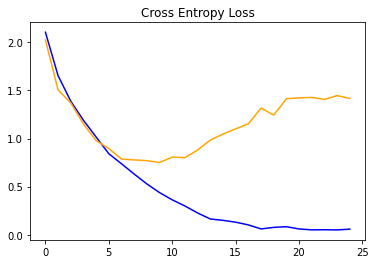

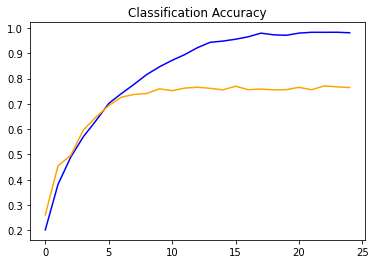

In [16]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

The cost we can see that it is stable and it is at epoch 15 that it is fixed at a value. Also the accuracy dances around 0.10. We can't say that it is a very good model.

Let's see what kind of predictions I'm getting on the test set (let's paint the images and their classifications)

In [17]:
predictions = model.predict(x_test)

In [18]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

We draw the first images, with the predictions and their real values (a total of 20 images, so as not to abuse your laptops).

We color the correct predictions in blue and the failures in red. But first I have printed the labels so that we have a reference to the graph.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


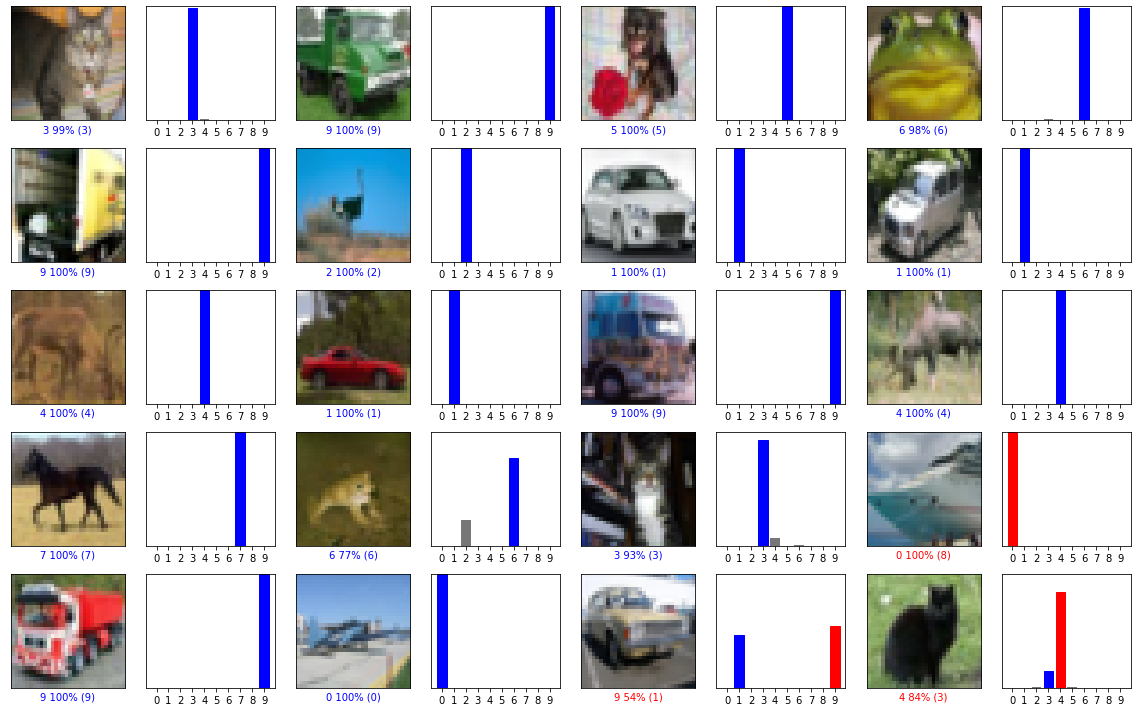

In [19]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()